In [1]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

In [116]:
#import keras
import tensorflow as tf
from keras import Model, Input
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout, Activation, Dot, Concatenate
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd

import time

from keras.losses import mean_squared_error
from keras.layers.merge import dot

In [2]:
movies = pd.read_csv(filepath_or_buffer="https://raw.githubusercontent.com/katipogluMustafa/cimrec/master/data/movielens_2020/movies.csv")
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [3]:
ratings = pd.read_csv(filepath_or_buffer="https://raw.githubusercontent.com/katipogluMustafa/cimrec/master/data/movielens_2020/ratings.csv")
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')
ratings['year'] = pd.DatetimeIndex(ratings['timestamp']).year
ratings['month'] = pd.DatetimeIndex(ratings['timestamp']).month
ratings['day'] = pd.DatetimeIndex(ratings['timestamp']).day
ratings

,userId,movieId,rating,timestamp,year,month,day
0,1,1,4.0,2000-07-30 18:45:03,2000,7,30
1,1,3,4.0,2000-07-30 18:20:47,2000,7,30
2,1,6,4.0,2000-07-30 18:37:04,2000,7,30
3,1,47,5.0,2000-07-30 19:03:35,2000,7,30
4,1,50,5.0,2000-07-30 18:48:51,2000,7,30
...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-03 21:53:22,2017,5,3
100832,610,168248,5.0,2017-05-03 22:21:31,2017,5,3
100833,610,168250,5.0,2017-05-08 19:50:47,2017,5,8
100834,610,168252,5.0,2017-05-03 21:19:12,2017,5,3


In [4]:
ratings["rating"].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## 1- Neural Network Based [Matrix Factorization](https://www.kaggle.com/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization)

In [5]:
df = ratings.copy()
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [6]:
# Creating Training and Validation Sets.
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(80886, 7) (19950, 7)


In [7]:
n_latent_factors=50
n_movies=len(ratings['movieId'].unique())
n_users=len(ratings['userId'].unique())

In [8]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

In [9]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [12]:
sim=dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

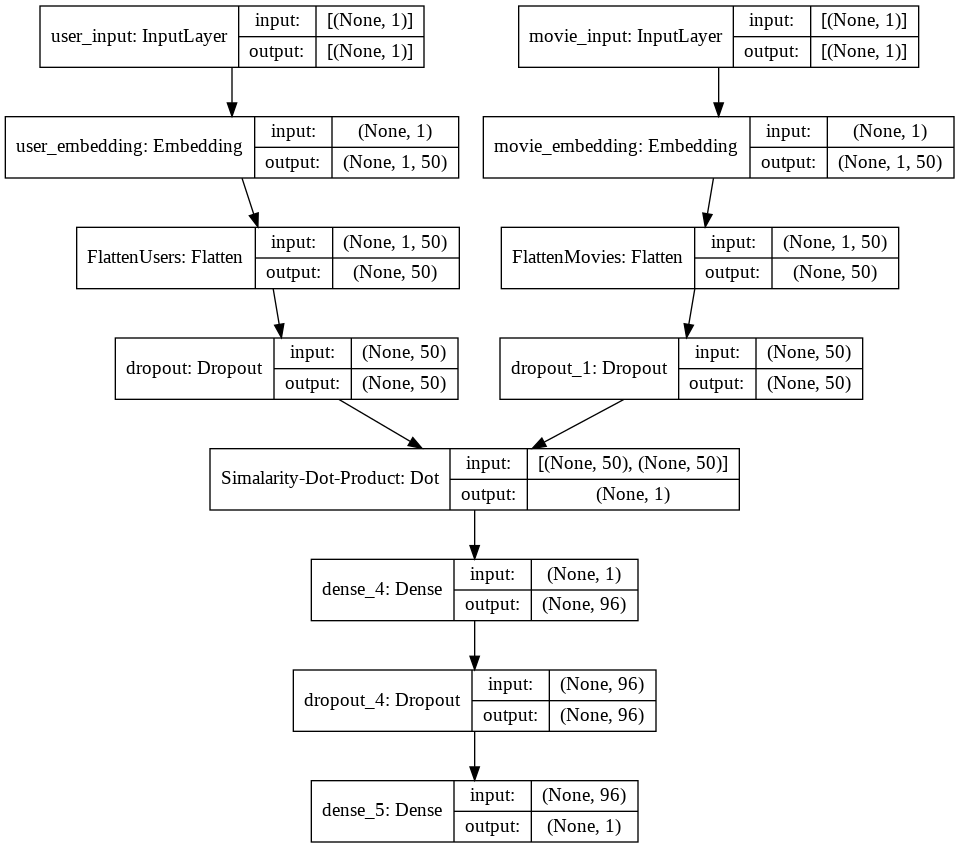

In [15]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model = Model([user_input, movie_input],nn_inp)
plot_model(nn_model, show_shapes=True) 

In [110]:
learning_rate = 0.001
batch_size=128
epochs=100

In [111]:
nn_model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [112]:
History = nn_model.fit([train.userId,train.movieId], train.rating, batch_size=batch_size,
                       epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Epoch 1/100
632/632 [==============================] - 5s 7ms/step - loss: 0.4121 - rmse: 0.6419 - val_loss: 0.7843 - val_rmse: 0.8856
Epoch 2/100
632/632 [==============================] - 4s 7ms/step - loss: 0.4172 - rmse: 0.6459 - val_loss: 0.7759 - val_rmse: 0.8809
Epoch 3/100
632/632 [==============================] - 4s 7ms/step - loss: 0.4070 - rmse: 0.6379 - val_loss: 0.7764 - val_rmse: 0.8812
Epoch 4/100
632/632 [==============================] - 4s 7ms/step - loss: 0.4089 - rmse: 0.6395 - val_loss: 0.7749 - val_rmse: 0.8803
Epoch 5/100
632/632 [==============================] - 5s 7ms/step - loss: 0.4063 - rmse: 0.6374 - val_loss: 0.7716 - val_rmse: 0.8784
Epoch 6/100
632/632 [==============================] - 4s 7ms/step - loss: 0.4054 - rmse: 0.6367 - val_loss: 0.7708 - val_rmse: 0.8780
Epoch 7/100
632/632 [==============================] - 4s 7ms/step - loss: 0.4046 - rmse: 0.6360 - val_loss: 0.7763 - val_rmse: 0.8811
Epoch 8/100
632/632 [==============================] - 

In [19]:
def predict_rating(model, userid, movieid):
    return model.predict([np.array([userid]), np.array([movieid])])[0][0]

In [20]:
TEST_USER = 448
user_ratings = df[df['userId'] == TEST_USER][['userId', 'movieId', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(nn_model, TEST_USER, x['movieId']), axis=1)
user_ratings

,userId,movieId,rating,prediction
70519,448,292,4.0,3.641060
70520,448,4,4.5,4.291234
70521,448,540,0.5,1.908321
70522,448,588,4.0,4.086226
70523,448,232,5.0,4.326530
70524,448,618,3.5,2.367435
70525,448,28,4.0,4.170185
70526,448,689,1.5,2.077968
70527,448,63,3.5,3.770920
70528,448,78,3.0,3.288050


## Year Based [Model](https://towardsdatascience.com/recommender-systems-from-learned-embeddings-f1d12288f278)

In [22]:
def UserMovieRatingYearModel(EMBEDDING_SIZE, NUM_USERS, NUM_MOVIES, ROW_COUNT):
    # User Model    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    # Movie Model
    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    # Timestamp Year Model
    year_input = Input(shape=(1,), name='rating_year')

    year_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=2021, input_length=ROW_COUNT, name='year_emb')(year_input)
    year_vec = Flatten(name='FlattenYear')(year_emb)

    year_model = Model(inputs=year_input, outputs=year_vec)
    

    # User Movie Rating Model
    merged = Concatenate(name="user_movie_rating_layer")([user_emb, movie_emb, year_emb])
    #merged = Dot(name = 'user_movie_rating_similarity_matrix', normalize = True, axes = 3)([user_emb, movie_emb, rating_emb])
    merged_dropout = Dropout(0.2)(merged)
    
    dense_1 = Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = Dense(1, name='result', activation="relu") (dense_4)
    
    model = Model([movie_input, user_input, year_input], result)
    return model, movie_model, user_model, year_model

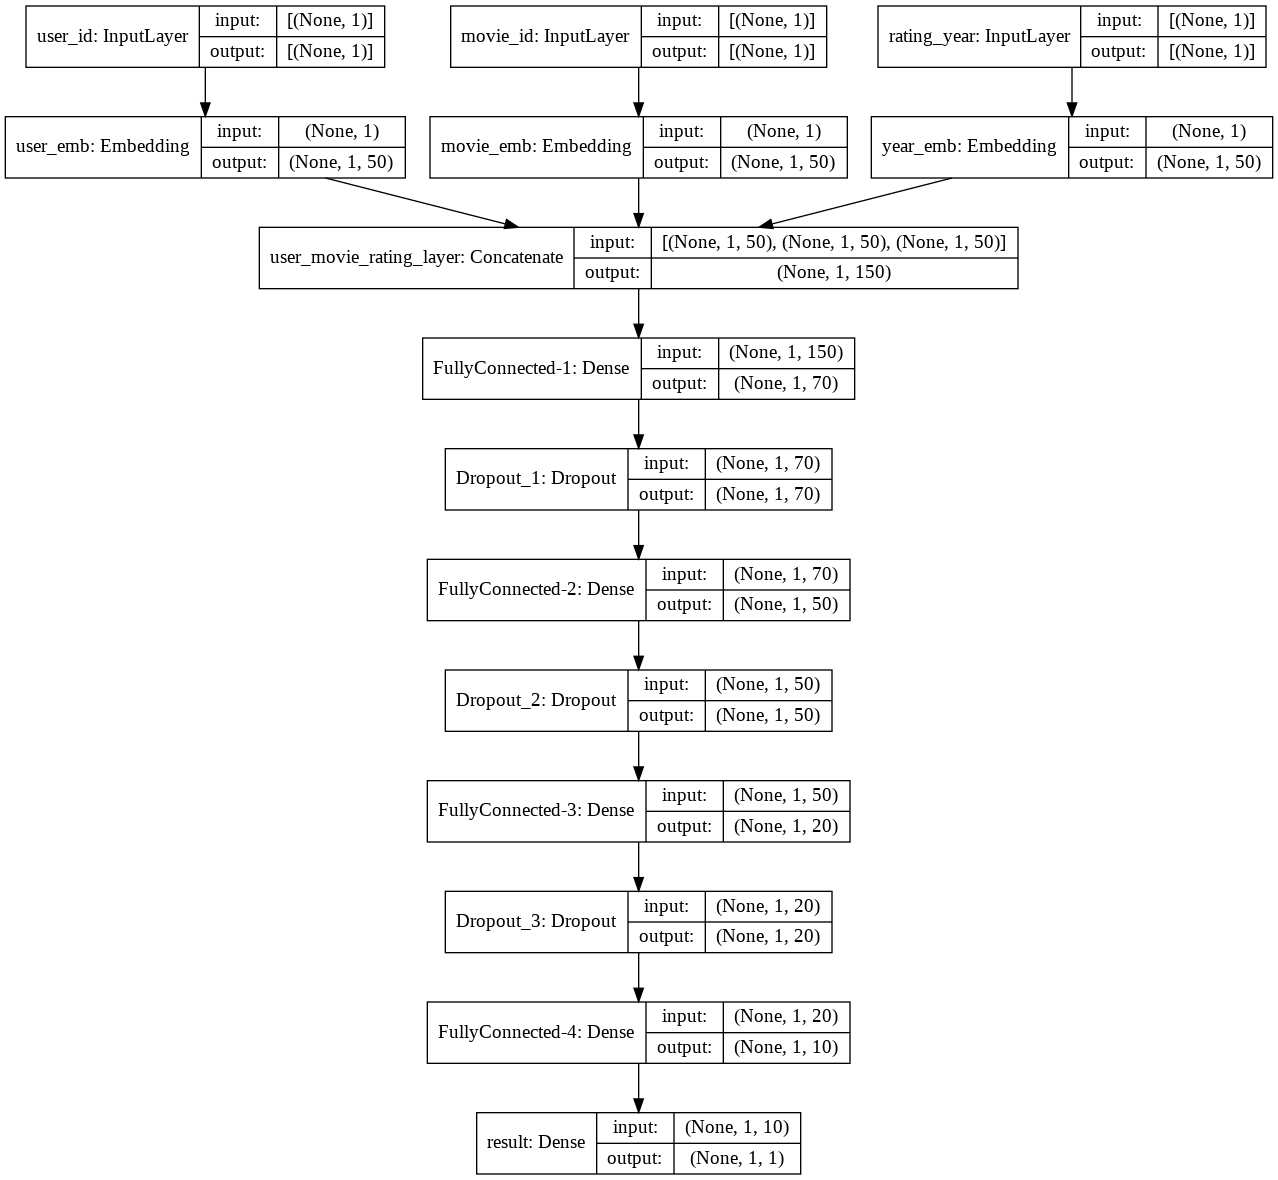

In [23]:
model, movie_model, user_model, rating_model = UserMovieRatingYearModel(n_latent_factors, n_movies, n_users, len(ratings))
plot_model(model, show_shapes=True) 

In [24]:
learning_rate = 0.001
batch_size = 128
epochs = 20

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [25]:
History = model.fit([train.userId, train.movieId, train.year], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year], valid.rating), verbose = 1)

Epoch 1/20
632/632 [==============================] - 7s 9ms/step - loss: 2.8189 - rmse: 1.5973 - val_loss: 0.8136 - val_rmse: 0.9020
Epoch 2/20
632/632 [==============================] - 5s 8ms/step - loss: 0.9180 - rmse: 0.9581 - val_loss: 0.8332 - val_rmse: 0.9128
Epoch 3/20
632/632 [==============================] - 5s 8ms/step - loss: 0.7979 - rmse: 0.8932 - val_loss: 0.9025 - val_rmse: 0.9500
Epoch 4/20
632/632 [==============================] - 5s 8ms/step - loss: 0.7436 - rmse: 0.8623 - val_loss: 0.8964 - val_rmse: 0.9468
Epoch 5/20
632/632 [==============================] - 5s 9ms/step - loss: 0.7155 - rmse: 0.8459 - val_loss: 0.8778 - val_rmse: 0.9369
Epoch 6/20
632/632 [==============================] - 5s 8ms/step - loss: 0.6988 - rmse: 0.8359 - val_loss: 0.8357 - val_rmse: 0.9141
Epoch 7/20
632/632 [==============================] - 5s 9ms/step - loss: 0.6708 - rmse: 0.8190 - val_loss: 0.8049 - val_rmse: 0.8971
Epoch 8/20
632/632 [==============================] - 5s 9ms/s

## Year and Month Based Model

In [26]:
def UserMovieRatingYearMonthModel(EMBEDDING_SIZE, NUM_USERS, NUM_MOVIES, ROW_COUNT):
    # User Model    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    # Movie Model
    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    # Timestamp Year Model
    year_input = Input(shape=(1,), name='rating_year')

    year_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=2021, input_length=ROW_COUNT, name='year_emb')(year_input)
    year_vec = Flatten(name='FlattenYear')(year_emb)

    year_model = Model(inputs=year_input, outputs=year_vec)
    
    # Timestamp Month Model
    month_input = Input(shape=(1,), name='rating_month')

    month_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=13, input_length=ROW_COUNT, name='month_emb')(month_input)
    month_vec = Flatten(name='FlattenYear')(month_emb)

    month_model = Model(inputs=month_input, outputs=month_vec)
    


    # User Movie Rating Model
    merged = Concatenate(name="user_movie_rating_layer")([user_emb, movie_emb, year_emb, month_emb])
    #merged = Dot(name = 'user_movie_rating_similarity_matrix', normalize = True, axes = 3)([user_emb, movie_emb, rating_emb])
    merged_dropout = Dropout(0.2)(merged)
    
    dense_1 = Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = Dense(1, name='result', activation="relu") (dense_4)
    
    model = Model([movie_input, user_input, year_input, month_input], result)
    return model, movie_model, user_model, year_model, month_model

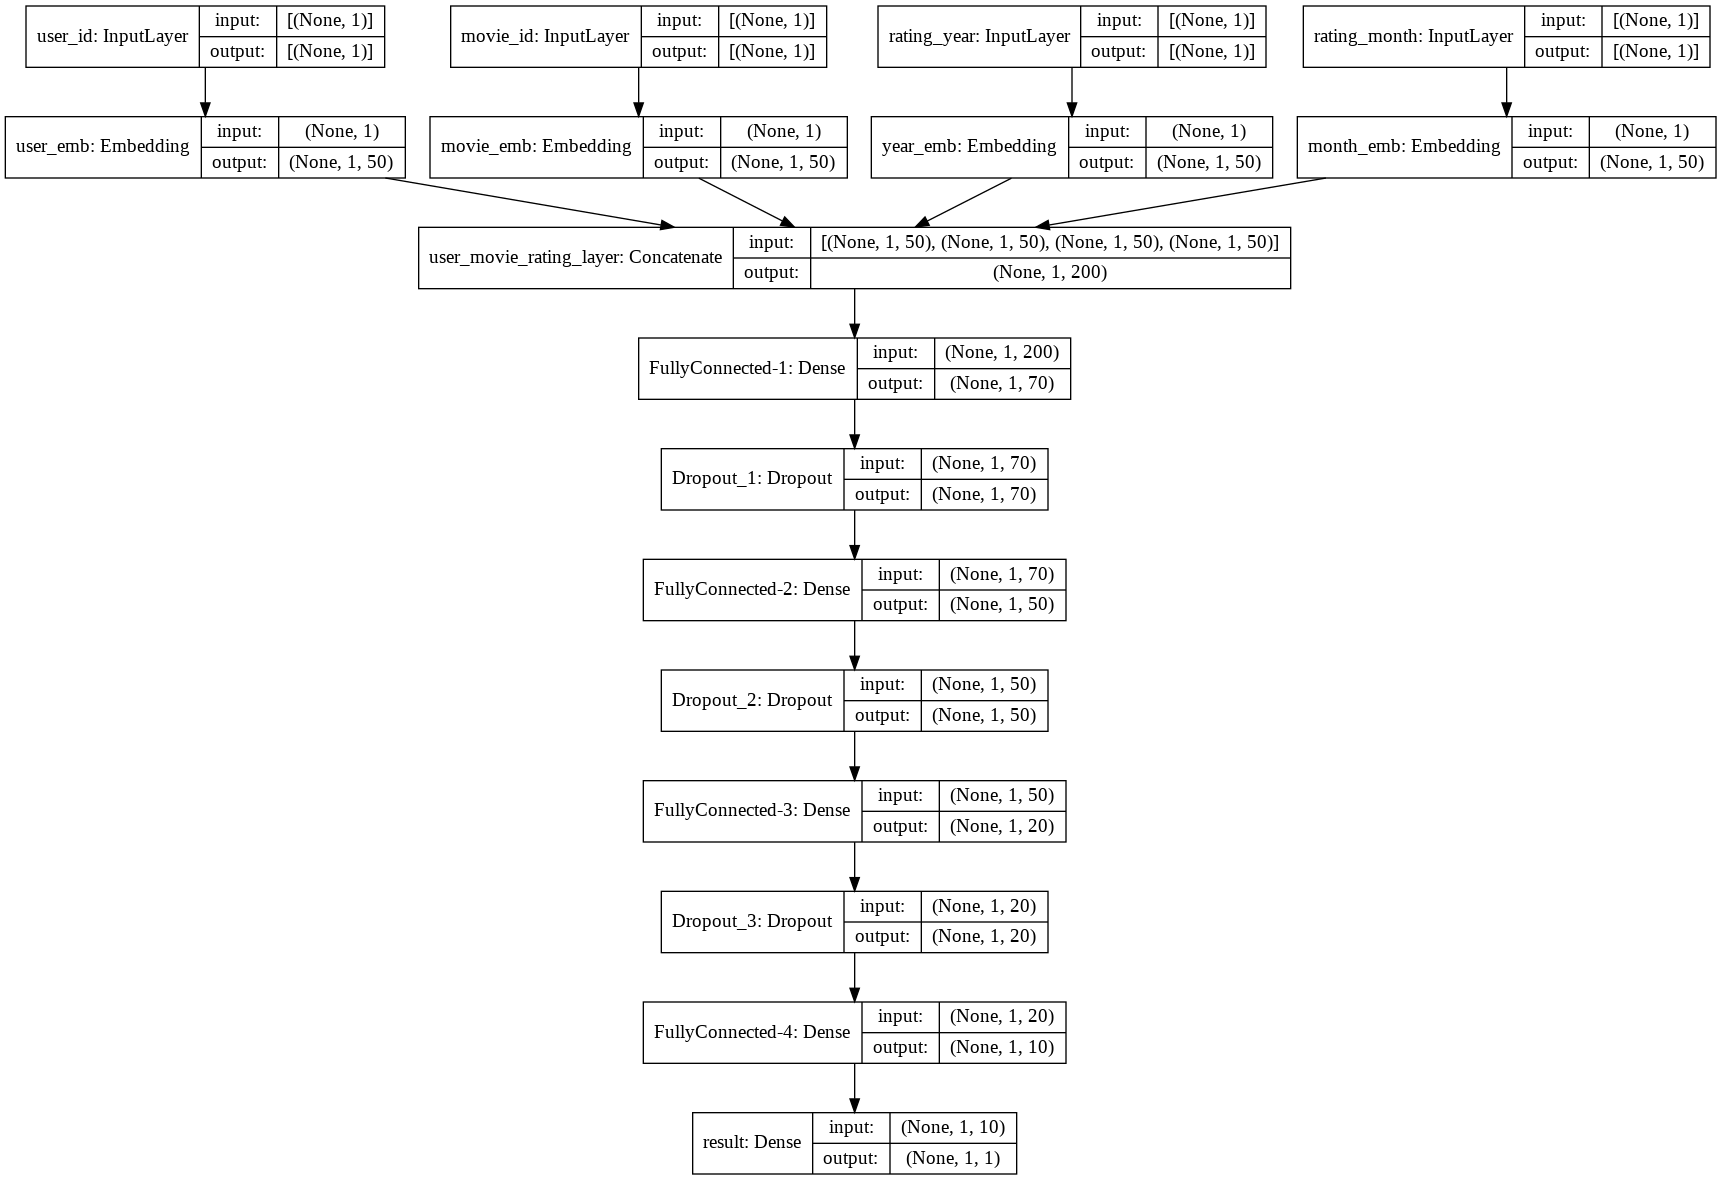

In [27]:
model, movie_model, user_model, rating_model, month_model = UserMovieRatingYearMonthModel(n_latent_factors, n_movies, n_users, len(ratings))
plot_model(model, show_shapes=True) 

In [28]:
learning_rate = 0.001
batch_size = 128
epochs = 20

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [29]:
History = model.fit([train.userId, train.movieId, train.year, train.month], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month], valid.rating), verbose = 1)

Epoch 1/20
632/632 [==============================] - 7s 10ms/step - loss: 2.4021 - rmse: 1.4817 - val_loss: 0.8156 - val_rmse: 0.9031
Epoch 2/20
632/632 [==============================] - 6s 9ms/step - loss: 0.8820 - rmse: 0.9392 - val_loss: 0.9190 - val_rmse: 0.9587
Epoch 3/20
632/632 [==============================] - 6s 9ms/step - loss: 0.7740 - rmse: 0.8798 - val_loss: 0.9052 - val_rmse: 0.9514
Epoch 4/20
632/632 [==============================] - 6s 10ms/step - loss: 0.7212 - rmse: 0.8492 - val_loss: 0.8116 - val_rmse: 0.9009
Epoch 5/20
632/632 [==============================] - 6s 10ms/step - loss: 0.6890 - rmse: 0.8300 - val_loss: 0.7789 - val_rmse: 0.8826
Epoch 6/20
632/632 [==============================] - 6s 9ms/step - loss: 0.6719 - rmse: 0.8196 - val_loss: 0.7819 - val_rmse: 0.8843
Epoch 7/20
632/632 [==============================] - 6s 9ms/step - loss: 0.6590 - rmse: 0.8118 - val_loss: 0.7562 - val_rmse: 0.8696
Epoch 8/20
632/632 [==============================] - 6s 9m

## Timestamp Based Model(Year-Month-Day)

In [30]:
def UserMovieRatingYearMonthDayModel(EMBEDDING_SIZE, NUM_USERS, NUM_MOVIES, ROW_COUNT):
    # User Model    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    # Movie Model
    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    # Timestamp Year Model
    year_input = Input(shape=(1,), name='rating_year')

    year_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=2021, input_length=ROW_COUNT, name='year_emb')(year_input)
    year_vec = Flatten(name='FlattenYear')(year_emb)

    year_model = Model(inputs=year_input, outputs=year_vec)
    
    # Timestamp Month Model
    month_input = Input(shape=(1,), name='rating_month')

    month_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=13, input_length=ROW_COUNT, name='month_emb')(month_input)
    month_vec = Flatten(name='FlattenYear')(month_emb)

    month_model = Model(inputs=month_input, outputs=month_vec)
    
    
    # Timestamp Day Model
    day_input = Input(shape=(1,), name='rating_day')

    day_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=32, input_length=ROW_COUNT, name='day_emb')(day_input)
    day_vec = Flatten(name='FlattenYear')(day_emb)

    day_model = Model(inputs=day_input, outputs=day_vec)
    

    # User Movie Rating Model
    merged = Concatenate(name="user_movie_rating_layer")([user_emb, movie_emb, year_emb, month_emb, day_emb])
    #merged = Dot(name = 'user_movie_rating_similarity_matrix', normalize = True, axes = 3)([user_emb, movie_emb, rating_emb])
    merged_dropout = Dropout(0.2)(merged)
    
    dense_1 = Dense(70,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(20,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(10,name='FullyConnected-4', activation='relu')(dropout_3)

    result = Dense(1, name='result', activation="relu") (dense_4)
    
    model = Model([movie_input, user_input, year_input, month_input, day_input], result)
    return model, movie_model, user_model, year_model, month_model, day_model

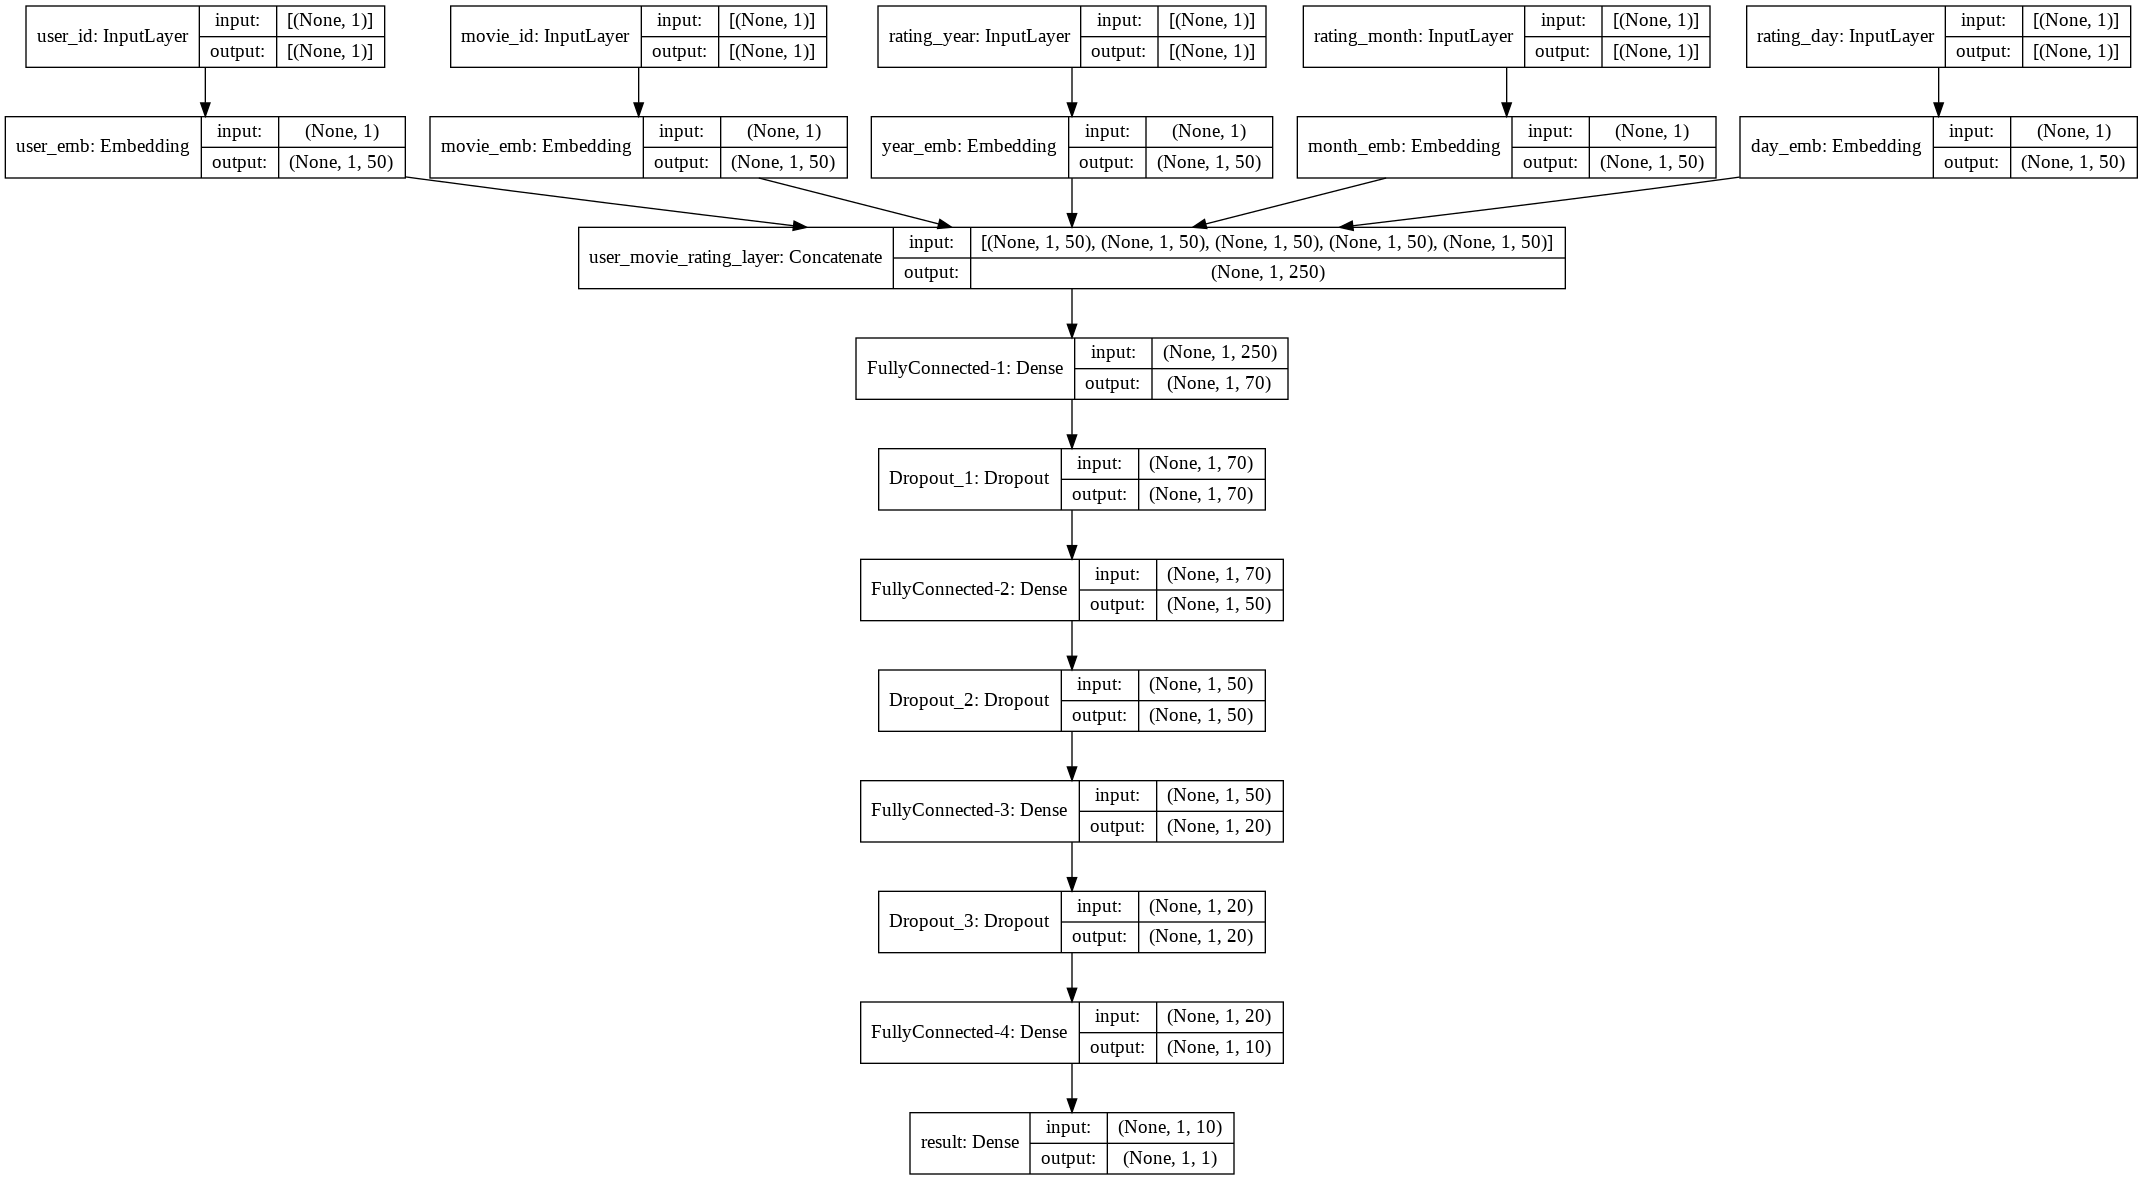

In [31]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel(n_latent_factors, n_movies, n_users, len(ratings))
plot_model(model, show_shapes=True) 

In [32]:
learning_rate = 0.001
batch_size = 128
epochs = 20

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

In [33]:
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), verbose = 1)

Epoch 1/20
632/632 [==============================] - 7s 10ms/step - loss: 2.7972 - rmse: 1.5935 - val_loss: 0.8184 - val_rmse: 0.9046
Epoch 2/20
632/632 [==============================] - 6s 9ms/step - loss: 0.8936 - rmse: 0.9453 - val_loss: 0.8882 - val_rmse: 0.9425
Epoch 3/20
632/632 [==============================] - 6s 9ms/step - loss: 0.7831 - rmse: 0.8849 - val_loss: 0.9941 - val_rmse: 0.9970
Epoch 4/20
632/632 [==============================] - 6s 9ms/step - loss: 0.7252 - rmse: 0.8515 - val_loss: 0.9473 - val_rmse: 0.9733
Epoch 5/20
632/632 [==============================] - 6s 9ms/step - loss: 0.7040 - rmse: 0.8390 - val_loss: 0.8077 - val_rmse: 0.8987
Epoch 6/20
632/632 [==============================] - 6s 9ms/step - loss: 0.6833 - rmse: 0.8266 - val_loss: 0.8260 - val_rmse: 0.9088
Epoch 7/20
632/632 [==============================] - 6s 9ms/step - loss: 0.6697 - rmse: 0.8183 - val_loss: 0.7890 - val_rmse: 0.8882
Epoch 8/20
632/632 [==============================] - 6s 9ms/

## Playing With Hyperparameters for Timestamp Based Neural Network

In [37]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel(n_latent_factors, n_movies, n_users, len(ratings))
learning_rate = 0.003
batch_size = 512
epochs = 100

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), verbose = 1)

Epoch 1/100
158/158 [==============================] - 3s 15ms/step - loss: 3.7297 - rmse: 1.8469 - val_loss: 0.8236 - val_rmse: 0.9075
Epoch 2/100
158/158 [==============================] - 2s 13ms/step - loss: 0.9343 - rmse: 0.9666 - val_loss: 0.9911 - val_rmse: 0.9956
Epoch 3/100
158/158 [==============================] - 2s 14ms/step - loss: 0.7987 - rmse: 0.8937 - val_loss: 0.8830 - val_rmse: 0.9397
Epoch 4/100
158/158 [==============================] - 2s 15ms/step - loss: 0.7344 - rmse: 0.8569 - val_loss: 0.8534 - val_rmse: 0.9238
Epoch 5/100
158/158 [==============================] - 2s 14ms/step - loss: 0.7088 - rmse: 0.8419 - val_loss: 0.8536 - val_rmse: 0.9239
Epoch 6/100
158/158 [==============================] - 2s 13ms/step - loss: 0.6807 - rmse: 0.8250 - val_loss: 0.8427 - val_rmse: 0.9180
Epoch 7/100
158/158 [==============================] - 2s 13ms/step - loss: 0.6714 - rmse: 0.8193 - val_loss: 0.8132 - val_rmse: 0.9018
Epoch 8/100
158/158 [===========================

In [43]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel(n_latent_factors, n_movies, n_users, len(ratings))
learning_rate = 0.007
batch_size = 512
epochs = 500

model.compile(optimizer=Adam(lr=learning_rate),
              loss=tf.keras.metrics.mean_squared_error, 
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), verbose = 1,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25))

Epoch 1/500
158/158 [==============================] - 4s 15ms/step - loss: 2.1662 - rmse: 1.4209 - val_loss: 0.7683 - val_rmse: 0.8765
Epoch 2/500
158/158 [==============================] - 2s 13ms/step - loss: 0.8501 - rmse: 0.9220 - val_loss: 0.7771 - val_rmse: 0.8816
Epoch 3/500
158/158 [==============================] - 2s 13ms/step - loss: 0.7586 - rmse: 0.8710 - val_loss: 0.7592 - val_rmse: 0.8713
Epoch 4/500
158/158 [==============================] - 2s 13ms/step - loss: 0.7053 - rmse: 0.8398 - val_loss: 0.7532 - val_rmse: 0.8679
Epoch 5/500
158/158 [==============================] - 2s 13ms/step - loss: 0.6831 - rmse: 0.8265 - val_loss: 0.7526 - val_rmse: 0.8675
Epoch 6/500
158/158 [==============================] - 2s 13ms/step - loss: 0.6682 - rmse: 0.8174 - val_loss: 0.7454 - val_rmse: 0.8633
Epoch 7/500
158/158 [==============================] - 2s 13ms/step - loss: 0.6524 - rmse: 0.8077 - val_loss: 0.7523 - val_rmse: 0.8674
Epoch 8/500
158/158 [===========================

In [45]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel(n_latent_factors, n_movies, n_users, len(ratings))
learning_rate = 0.001
batch_size = 128
epochs = 500

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), verbose = 1,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25))

Epoch 1/500
632/632 [==============================] - 8s 10ms/step - loss: 2.5320 - rmse: 1.5177 - val_loss: 0.9926 - val_rmse: 0.9963
Epoch 2/500
632/632 [==============================] - 6s 9ms/step - loss: 0.8665 - rmse: 0.9308 - val_loss: 0.9090 - val_rmse: 0.9534
Epoch 3/500
632/632 [==============================] - 6s 9ms/step - loss: 0.7516 - rmse: 0.8669 - val_loss: 0.8465 - val_rmse: 0.9201
Epoch 4/500
632/632 [==============================] - 6s 9ms/step - loss: 0.7020 - rmse: 0.8378 - val_loss: 0.7944 - val_rmse: 0.8913
Epoch 5/500
632/632 [==============================] - 6s 9ms/step - loss: 0.6735 - rmse: 0.8206 - val_loss: 0.7786 - val_rmse: 0.8824
Epoch 6/500
632/632 [==============================] - 6s 9ms/step - loss: 0.6623 - rmse: 0.8138 - val_loss: 0.7578 - val_rmse: 0.8705
Epoch 7/500
632/632 [==============================] - 6s 9ms/step - loss: 0.6484 - rmse: 0.8052 - val_loss: 0.7660 - val_rmse: 0.8752
Epoch 8/500
632/632 [==============================] -

In [52]:
def UserMovieRatingYearMonthDayModel2(EMBEDDING_SIZE, NUM_USERS, NUM_MOVIES, ROW_COUNT):
    # User Model    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    # Movie Model
    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    # Timestamp Year Model
    year_input = Input(shape=(1,), name='rating_year')

    year_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=2021, input_length=ROW_COUNT, name='year_emb')(year_input)
    year_vec = Flatten(name='FlattenYear')(year_emb)

    year_model = Model(inputs=year_input, outputs=year_vec)
    
    # Timestamp Month Model
    month_input = Input(shape=(1,), name='rating_month')

    month_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=13, input_length=ROW_COUNT, name='month_emb')(month_input)
    month_vec = Flatten(name='FlattenYear')(month_emb)

    month_model = Model(inputs=month_input, outputs=month_vec)
    
    
    # Timestamp Day Model
    day_input = Input(shape=(1,), name='rating_day')

    day_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=32, input_length=ROW_COUNT, name='day_emb')(day_input)
    day_vec = Flatten(name='FlattenYear')(day_emb)

    day_model = Model(inputs=day_input, outputs=day_vec)
    

    # User Movie Rating Model
    merged = Concatenate(name="user_movie_rating_layer")([user_emb, movie_emb, year_emb, month_emb, day_emb])
    #merged = Dot(name = 'user_movie_rating_similarity_matrix', normalize = True, axes = 3)([user_emb, movie_emb, rating_emb])
    merged_dropout = Dropout(0.2)(merged)
    
    dense_1 = Dense(612,name='FullyConnected-1')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(306,name='FullyConnected-2')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(154,name='FullyConnected-3')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(154,name='FullyConnected-4')(dropout_3)
    dropout_4 = Dropout(0.4,name='Dropout_4')(dense_4)

    dense_5 = Dense(154,name='FullyConnected-5')(dropout_4)
    dropout_5 = Dropout(0.4,name='Dropout_5')(dense_5)

    dense_6 = Dense(306,name='FullyConnected-6')(dropout_5)
    dropout_6 = Dropout(0.2,name='Dropout_6')(dense_6)

    dense_7 = Dense(612,name='FullyConnected-7')(dropout_6)
    dropout_7 = Dropout(0.2,name='Dropout_7')(dense_7)

    dense_8 = Dense(612,name='FullyConnected-8', activation='relu')(dropout_7)

    result = Dense(1, name='result', activation="relu") (dense_8)
    
    model = Model([movie_input, user_input, year_input, month_input, day_input], result)
    return model, movie_model, user_model, year_model, month_model, day_model

In [49]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel2(n_latent_factors, n_movies, n_users, len(ratings))
learning_rate = 0.001
batch_size = 128
epochs = 500

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, batch_size=batch_size, epochs =epochs, validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), verbose = 1,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25))

Epoch 1/500
632/632 [==============================] - 26s 38ms/step - loss: 1.8146 - rmse: 1.2999 - val_loss: 0.8338 - val_rmse: 0.9131
Epoch 2/500
632/632 [==============================] - 24s 38ms/step - loss: 0.8059 - rmse: 0.8977 - val_loss: 0.7760 - val_rmse: 0.8809
Epoch 3/500
632/632 [==============================] - 24s 38ms/step - loss: 0.7508 - rmse: 0.8664 - val_loss: 0.7852 - val_rmse: 0.8861
Epoch 4/500
632/632 [==============================] - 24s 38ms/step - loss: 0.7229 - rmse: 0.8502 - val_loss: 0.7651 - val_rmse: 0.8747
Epoch 5/500
632/632 [==============================] - 24s 38ms/step - loss: 0.7157 - rmse: 0.8459 - val_loss: 0.7604 - val_rmse: 0.8720
Epoch 6/500
632/632 [==============================] - 24s 38ms/step - loss: 0.6955 - rmse: 0.8339 - val_loss: 0.7532 - val_rmse: 0.8679
Epoch 7/500
632/632 [==============================] - 24s 38ms/step - loss: 0.6890 - rmse: 0.8300 - val_loss: 0.7828 - val_rmse: 0.8847
Epoch 8/500
632/632 [====================

In [126]:
def UserMovieRatingYearMonthDayModel3(EMBEDDING_SIZE, NUM_USERS, NUM_MOVIES, ROW_COUNT):
    # User Model    
    user_input = Input(shape=(1,), name='user_id')

    user_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = Flatten(name='FlattenUser')(user_emb)

    user_model = Model(inputs=user_input, outputs=user_vec)

    # Movie Model
    movie_input = Input(shape=(1,), name='movie_id')

    movie_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = Flatten(name='FlattenMovie')(movie_emb)

    movie_model = Model(inputs=movie_input, outputs=movie_vec)
    
    # Timestamp Year Model
    year_input = Input(shape=(1,), name='rating_year')

    year_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=2021, input_length=ROW_COUNT, name='year_emb')(year_input)
    year_vec = Flatten(name='FlattenYear')(year_emb)

    year_model = Model(inputs=year_input, outputs=year_vec)
    
    # Timestamp Month Model
    month_input = Input(shape=(1,), name='rating_month')

    month_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=13, input_length=ROW_COUNT, name='month_emb')(month_input)
    month_vec = Flatten(name='FlattenYear')(month_emb)

    month_model = Model(inputs=month_input, outputs=month_vec)
    
    
    # Timestamp Day Model
    day_input = Input(shape=(1,), name='rating_day')

    day_emb = Embedding(output_dim=EMBEDDING_SIZE, input_dim=32, input_length=ROW_COUNT, name='day_emb')(day_input)
    day_vec = Flatten(name='FlattenYear')(day_emb)

    day_model = Model(inputs=day_input, outputs=day_vec)
    

    # User Movie Rating Model
    merged = Concatenate(name="user_movie_rating_layer")([user_emb, movie_emb, year_emb, month_emb, day_emb])
    #merged = Dot(name = 'user_movie_rating_similarity_matrix', normalize = True, axes = 3)([user_emb, movie_emb, rating_emb])
    merged_dropout = Dropout(0.2)(merged)
    
    dense_1 = Dense(64,name='FullyConnected-1', activation='relu')(merged)
    dropout_1 = Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = Dense(64,name='FullyConnected-2', activation='softmax')(dropout_1)
    dropout_2 = Dropout(0.2,name='Dropout_2')(dense_2)

    dense_3 = Dense(64,name='FullyConnected-3', activation='relu')(dropout_2)
    dropout_3 = Dropout(0.2,name='Dropout_3')(dense_3)

    dense_4 = Dense(64,name='FullyConnected-4', activation='linear')(dropout_3)
    dropout_4 = Dropout(0.2,name='Dropout_4')(dense_4)

    dense_5 = Dense(64,name='FullyConnected-5', activation='relu')(dropout_4)
    dropout_5 = Dropout(0.4,name='Dropout_5')(dense_5)

    dense_6 = Dense(64,name='FullyConnected-6', activation='softmax')(dropout_5)
    dropout_6 = Dropout(0.2,name='Dropout_6')(dense_6)

    dense_7 = Dense(64,name='FullyConnected-7', activation='relu')(dropout_6)
    dropout_7 = Dropout(0.2,name='Dropout_7')(dense_7)

    dense_8 = Dense(64,name='FullyConnected-8', activation='softsign')(dropout_7)
    result = Dense(1, name='result', activation="relu") (dense_8)
    
    model = Model([movie_input, user_input, year_input, month_input, day_input], result)
    return model, movie_model, user_model, year_model, month_model, day_model

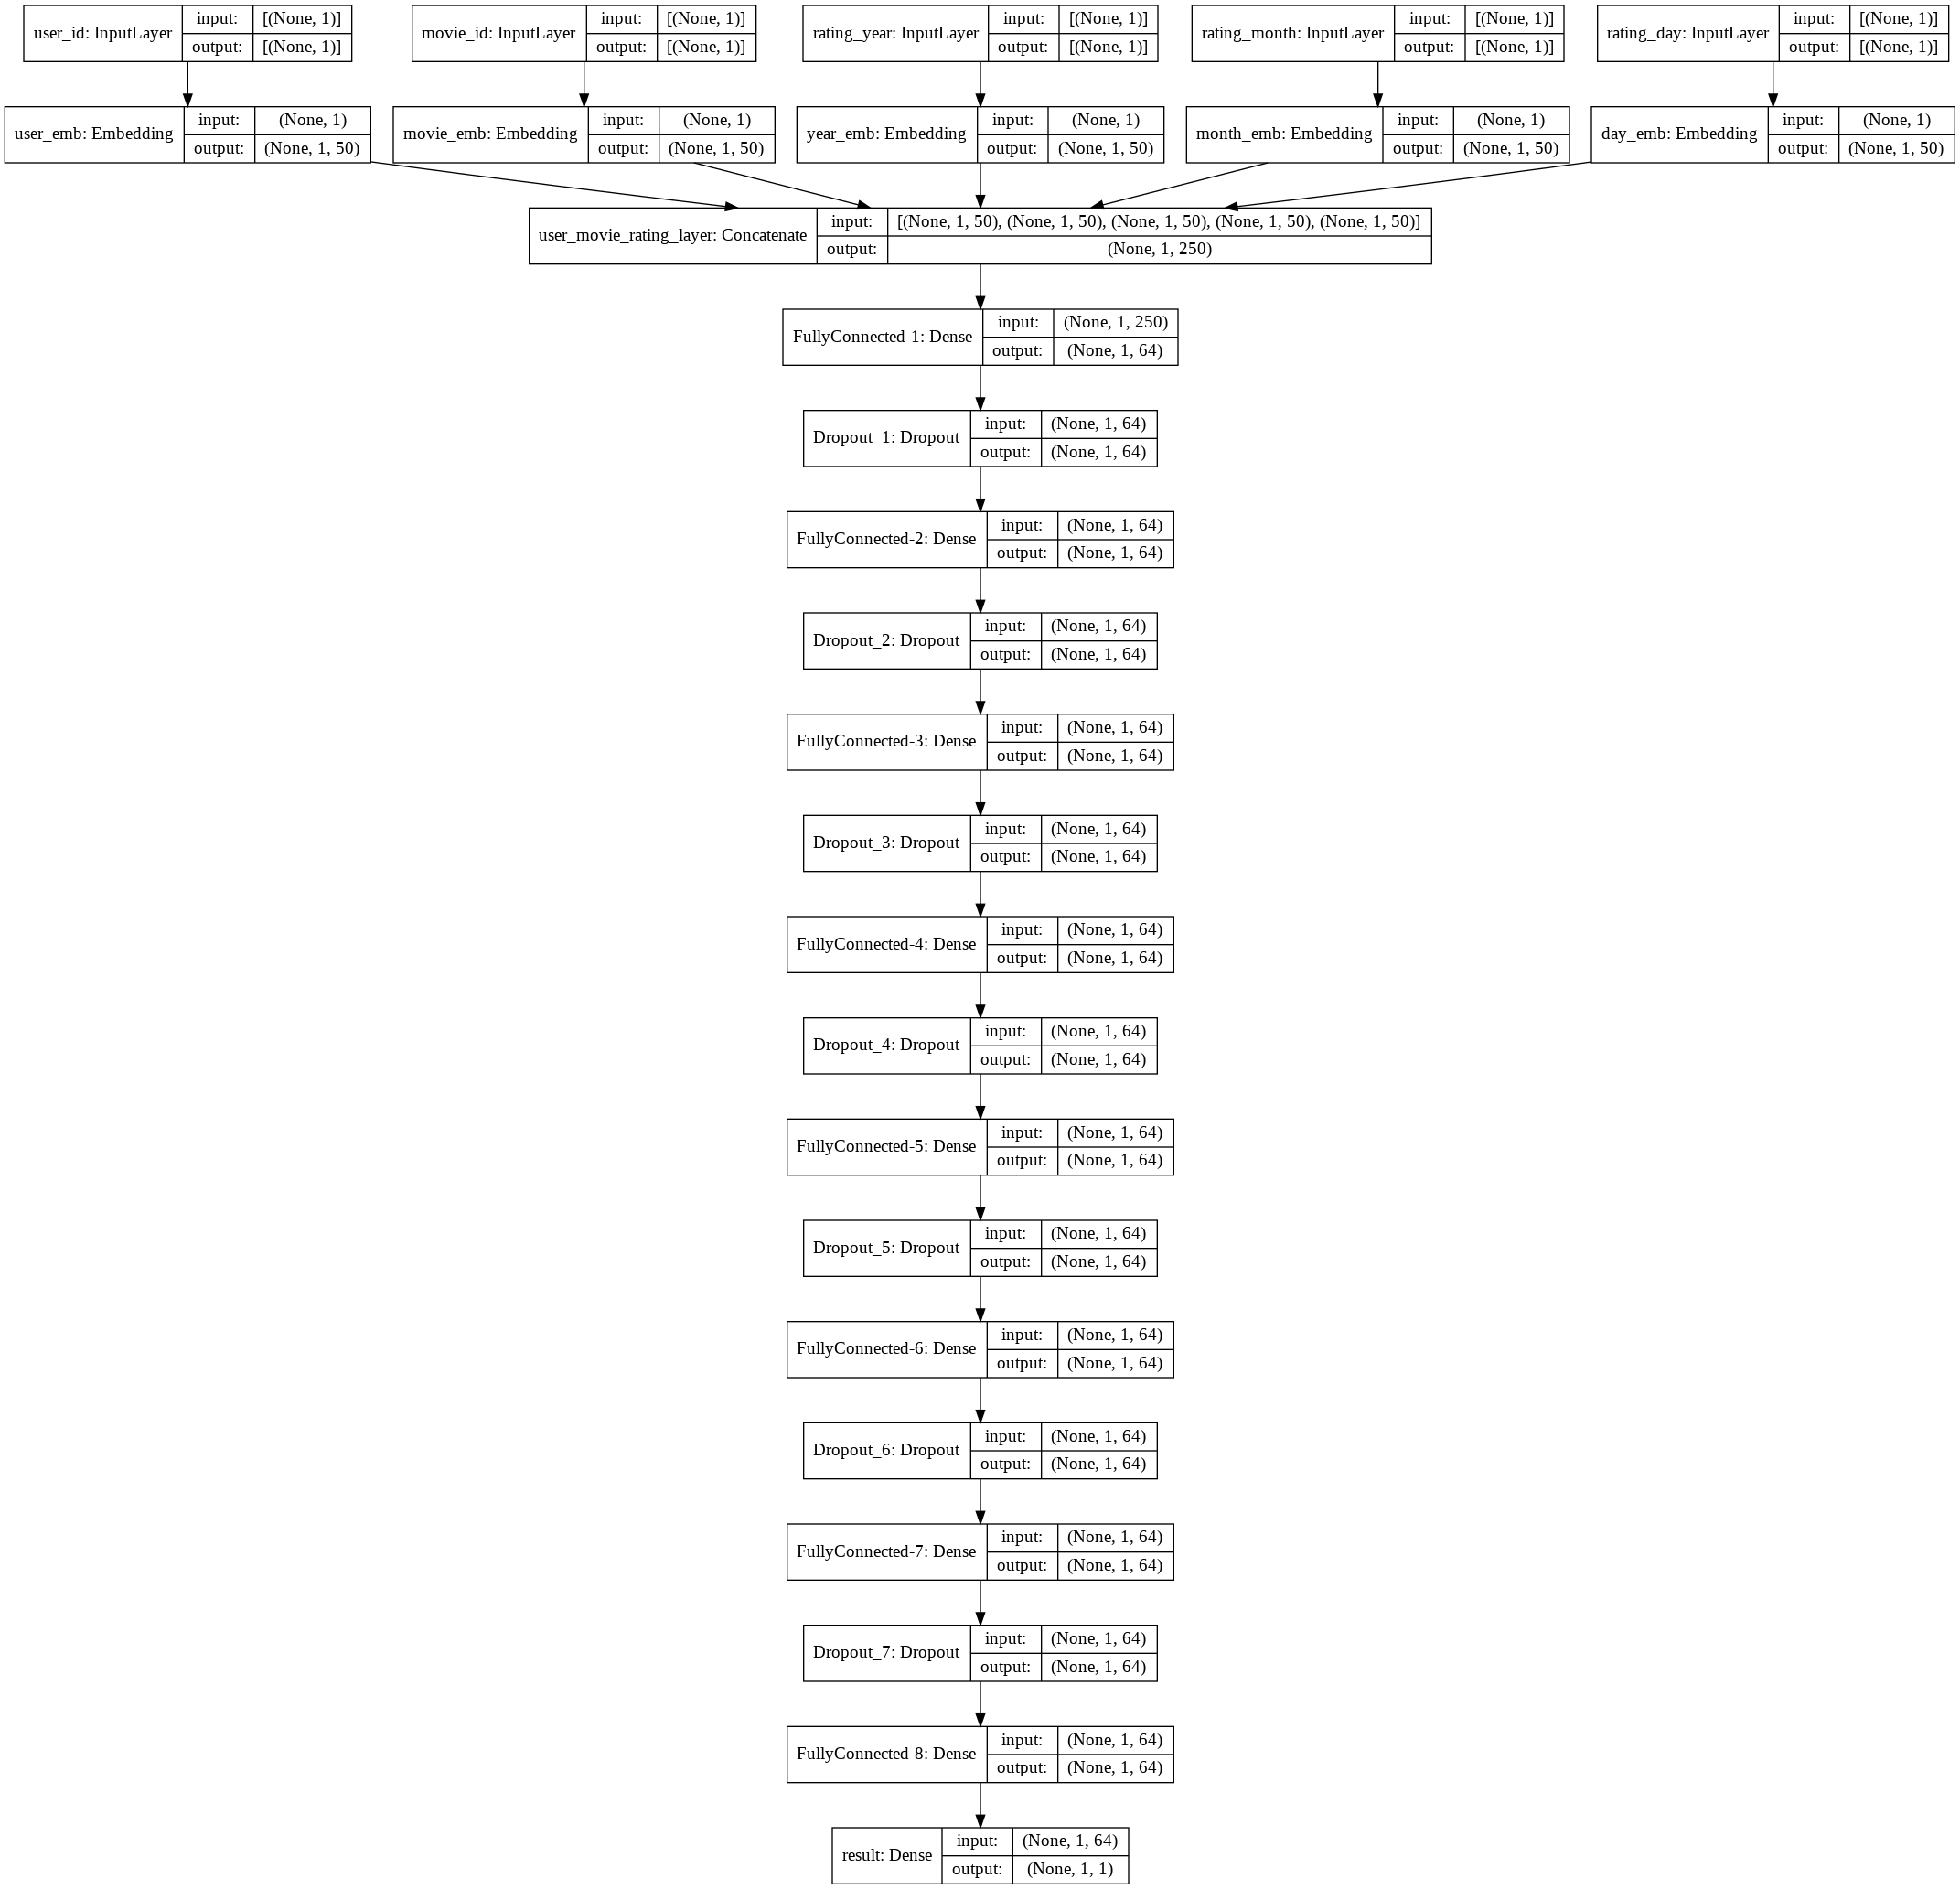

In [130]:
plot_model(model, show_shapes=True)

In [129]:
model, movie_model, user_model, rating_model, month_model, day_model = UserMovieRatingYearMonthDayModel3(n_latent_factors, n_movies, n_users, len(ratings))
learning_rate = 0.0001
batch_size = 512
epochs = 100

model.compile(optimizer=Adam(lr=learning_rate),loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
History = model.fit([train.userId, train.movieId, train.year, train.month, train.day], train.rating, 
                    batch_size=batch_size, epochs =epochs, 
                    validation_data = ([valid.userId, valid.movieId, valid.year, valid.month, valid.day], valid.rating), 
                    verbose = 1,
                    callbacks=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15))

Epoch 1/100
158/158 [==============================] - 5s 22ms/step - loss: 12.5158 - rmse: 3.5368 - val_loss: 8.3278 - val_rmse: 2.8858
Epoch 2/100
158/158 [==============================] - 3s 20ms/step - loss: 6.2387 - rmse: 2.4861 - val_loss: 1.4148 - val_rmse: 1.1894
Epoch 3/100
158/158 [==============================] - 3s 19ms/step - loss: 1.6090 - rmse: 1.2681 - val_loss: 1.0749 - val_rmse: 1.0368
Epoch 4/100
158/158 [==============================] - 3s 20ms/step - loss: 1.2901 - rmse: 1.1358 - val_loss: 1.0634 - val_rmse: 1.0312
Epoch 5/100
158/158 [==============================] - 3s 20ms/step - loss: 1.2183 - rmse: 1.1038 - val_loss: 1.0542 - val_rmse: 1.0268
Epoch 6/100
158/158 [==============================] - 3s 19ms/step - loss: 1.1678 - rmse: 1.0806 - val_loss: 1.0239 - val_rmse: 1.0119
Epoch 7/100
158/158 [==============================] - 3s 19ms/step - loss: 1.0894 - rmse: 1.0437 - val_loss: 0.8629 - val_rmse: 0.9289
Epoch 8/100
158/158 [==========================